In [1]:
%cd ..

c:\Users\nata0\c3


C:\Users\nata0\AppData\Roaming\Python\Python310\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib

from src.util import make_player_df_from_playdf

pd.set_option("display.max_columns", None)
# pd.set_option('display.max_rows', None)

In [9]:
data_dir = "data/unofficial/2023041506"
p_play = os.path.join(data_dir, "play.csv")
p_tracking = os.path.join(data_dir, "tracking.csv")
play_df = pd.read_csv(p_play, encoding="ansi")
tracking_df = pd.read_csv(p_tracking)

fps = 25

In [6]:
def plot_tracking(tracking_df):
    """
    HA 列の値
        0 : ボール（★）
        1 : ホーム（●）
        2 : アウェー（●）
    """
    # データを役割ごとに分割
    ball = tracking_df[tracking_df["HA"] == 0]
    home = tracking_df[tracking_df["HA"] == 1]
    away = tracking_df[tracking_df["HA"] == 2]

    fig, ax = plt.subplots()
    ax.scatter(home["X"], home["Y"], c="r", marker="o", s=20, label="Home")
    ax.scatter(away["X"], away["Y"], c="g", marker="o", s=20, label="Away")
    ax.scatter(ball["X"], ball["Y"], c="b", marker="*", s=80, label="Ball")  # ★ を使用

    ax.set_aspect("equal")
    ax.set_xlim(-5250.0, 5250.0)  # 1 point = 0.01 m
    ax.set_ylim(-3400.0, 3400.0)
    ax.legend()
    plt.show()


def get_nearest_ball_player(group):
    # ボール（HA == 0）の位置を取得
    ball_row = group[group["HA"] == 0].iloc[0]
    ball_x, ball_y = ball_row["X"], ball_row["Y"]

    # プレイヤー（HA != 0）のデータを取得
    players = group[group["HA"] != 0].copy()

    # 距離を計算
    players["distance"] = np.sqrt(
        (players["X"] - ball_x) ** 2 + (players["Y"] - ball_y) ** 2
    )

    # 最も近いプレイヤーの行を取得
    nearest_player = players.loc[players["distance"].idxmin()]

    return int(nearest_player["HA"]), int(nearest_player["No"])

In [14]:
# 時間間隔の計算
dt = 1.0 / fps

# 速度を m/s に変換
speed_in_mps = tracking_df["Speed"] / 3.6

# 'HA' と 'No' でグループ化し、グループ内で差分を計算
# これにより、選手の境界を越えて差分が計算されるのを防ぐ
acceleration = (
    speed_in_mps.groupby([tracking_df["HA"], tracking_df["No"]]).diff().fillna(0) / dt
)

# 'Acceleration' 列としてデータフレームに追加する
tracking_df["Acceleration"] = acceleration

tracking_df

,GameID,Frame,HA,SysTarget,No,X,Y,Speed,Acceleration
0,2023041506,1444962,1,10,2,2302,-58,0.00,0.000000
1,2023041506,1444962,1,19,5,2019,-1458,0.00,0.000000
2,2023041506,1444962,1,9,10,1148,396,0.00,0.000000
3,2023041506,1444962,1,5,13,842,-1731,0.00,0.000000
4,2023041506,1444962,1,25,14,1839,-124,0.00,0.000000
...,...,...,...,...,...,...,...,...,...
1026119,2023041506,1490697,2,7,16,-2572,2168,3.30,1.736111
1026120,2023041506,1490697,2,12,18,-1449,2514,3.74,1.388889
1026121,2023041506,1490697,2,9,19,-2751,3365,1.61,0.694444
1026122,2023041506,1490697,2,10,23,-3324,1139,3.97,0.000000


<Axes: ylabel='Frequency'>

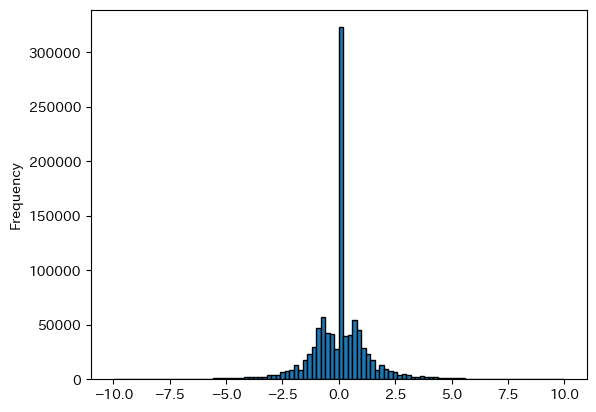

In [17]:
tracking_df["Acceleration"].plot.hist(bins=100, range=(-10, 10), edgecolor="black")

Frame: 1451037
            GameID    Frame  HA  SysTarget  No     X    Y  Speed  Acceleration
135357  2023041506  1451037   1         21  40 -2062 -386  14.57     -2.013889


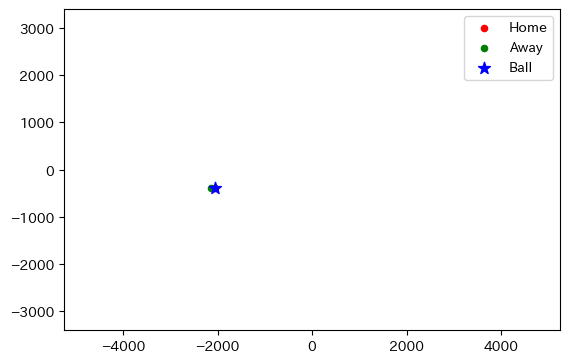

In [20]:
in_play_frame = tracking_df.loc[tracking_df["HA"] == 0, "Frame"].unique()
in_play_tracking_df = tracking_df.loc[tracking_df["Frame"].isin(in_play_frame)]

for frame_id, in_play_group in in_play_tracking_df.groupby("Frame"):
    # 背負うとは[ゴール][敵選手][選手][ボール]の順に並ぶこと

    in_play_group
    ball = in_play_group.loc[in_play_group["HA"] == 0, ["X", "Y"]]
    nearest_ball_player_ha, nearest_ball_player_no = get_nearest_ball_player(
        in_play_group
    )
    nearest_player = in_play_group.loc[
        (in_play_group["HA"] == nearest_ball_player_ha)
        & (in_play_group["No"] == nearest_ball_player_no)
    ]
    (
        nearest_ball_enemy_player_ha,
        nearest_ball_enemy_player_no,
    ) = get_nearest_ball_player(
        in_play_group[in_play_group["HA"] != nearest_ball_player_ha]
    )
    nearest_enemy_player = in_play_group.loc[
        (in_play_group["HA"] == nearest_ball_enemy_player_ha)
        & (in_play_group["No"] == nearest_ball_enemy_player_no)
    ]

    meter_threshold = 1.0 * 100  # m

    # meter_threshold [m] 以上離れている場合は無視
    if np.linalg.norm(nearest_player[["X", "Y"]].values - ball[["X", "Y"]].values) > 1:
        continue
    if (
        np.linalg.norm(
            nearest_enemy_player[["X", "Y"]].values - nearest_player[["X", "Y"]].values
        )
        > meter_threshold
    ):
        continue

    # x座標の位置関係が[low][ゴール][敵選手][選手][ボール][high]の順に並ぶか確認
    directoin = 1 if nearest_player["HA"].iloc[0] == 1 else -1

    if (nearest_player["X"].iloc[0] - ball["X"].iloc[0]) * directoin > 0:
        continue
    if (
        nearest_enemy_player["X"].iloc[0] - nearest_player["X"].iloc[0]
    ) * directoin > 0:
        continue

    # 選手が減速(減速 ≤ −2 m/s²)しているかを確認
    if nearest_player["Acceleration"].iloc[0] > -2:
        continue

    print(f"Frame: {frame_id}")
    print(nearest_player)
    plot_tracking(
        in_play_group.loc[
            ball.index.to_list()
            + nearest_player.index.to_list()
            + nearest_enemy_player.index.to_list()
        ]
    )
    break

In [21]:
in_play_group.loc[
    ball.index.to_list()
    + nearest_player.index.to_list()
    + nearest_enemy_player.index.to_list()
]

,GameID,Frame,HA,SysTarget,No,X,Y,Speed,Acceleration
135347,2023041506,1451037,0,0,0,-2062,-386,0.00,0.000000
135357,2023041506,1451037,1,21,40,-2062,-386,14.57,-2.013889
135365,2023041506,1451037,2,1,16,-2143,-391,25.99,-6.597222
